In [18]:
import cv2
import os
import math
from PIL import ImageDraw



# haarcascade

In [ ]:
def crop_face_from_path(img_path) :
    print(f"face path={img_path}")
    img = cv2.imread(img_path)
    print(img.shape)
    return crop_face(img)
    
def crop_face(img):
    # Convert into grayscale
    img2 = img.copy()
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Detect faces
    face_detector = cv2.CascadeClassifier('./faceutil/haarcascade_frontalface_default.xml')
    faces = face_detector.detectMultiScale(img, scaleFactor=1.1, minNeighbors=4, minSize=(120,120))
    # Draw rectangle around the faces
    print(f"face count={len(faces)}")
    if len(faces) > 0:
        face_array = []
        pad = 30
        for (x, y, w, h) in faces:
            cropped_face = gray_img[y-pad : y+h+pad , x-pad : x+w+pad]
            face_array.append(cropped_face)
        return face_array
    else:
        return None
    # 
        cv2.rectangle(img2, (x, y), (x+w, y+h), (255, 0, 0), 2)
        cv2.imshow(img2)
        return 

# D:/workspaces/beface/face-server/dl/src/test/kodonho/org.jpg
test_path = '../data/small_vgg/train/n000001/0001_01.jpg'
print(os.path.isfile(test_path))
faces = crop_face_from_path(test_path)

if not faces is None:
    c=0
    for face in faces :
        c+=1
        cv2.imshow("face{}".format(c), face)
    cv2.waitKey(0)
else:
    print("no face")
import os

True
face path=../data/small_vgg/train/n000001/0001_01.jpg
(227, 199, 3)
face count=1


In [ ]:
def crop_face_from_path(img_path) :
    print(f"face path={img_path}", os.path.isfile(img_path))
    img = cv2.imread(img_path)
    return crop_face(img)
    
def crop_face(img):
    # Convert into grayscale
    img2 = img.copy()
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Detect faces
    face_detector = cv2.CascadeClassifier('./faceutil/haarcascade_frontalface_default.xml')
    faces = face_detector.detectMultiScale(img, scaleFactor=1.1, minNeighbors=4, minSize=(120,120))
    # Draw rectangle around the faces
    print(f"face count={len(faces)}")
    if len(faces) > 0:
        face_array = []
        pad = 30
        for (x, y, w, h) in faces:
            cropped_face = gray_img[y-pad : y+h+pad , x-pad : x+w+pad]
            face_array.append(cropped_face)
#             cv2.rectangle(img2, (x, y), (x+w, y+h), (255, 0, 0), 2)
#             cv2.imshow('',img2)
        return face_array
    else:
        return None

In [ ]:
file_path = '../data/small_vgg/train/n000001/0001_01.jpg'
faces = crop_face_from_path(test_path)


In [ ]:
old_dir = '../data/small_vgg/train'
new_dir = '../data/small_vgg_112x112/train'
print(os.path.isdir(old_dir), os.path.isdir(new_dir) )

In [ ]:
old_dir_list = os.listdir(old_dir)
len(old_dir_list)

In [ ]:
for root, dirs, files in os.walk(old_dir):
#     print(dirs)
    people_name = os.path.split(root)[1]
    print(people_name)
    new_people_dir = os.path.join(new_dir, people_name)
    try:
        os.mkdir(new_people_dir)
    except Exception as err:
        print(err)
        
    # face recognition and  save	
    for i, file in enumerate(files):
        input_image_path = os.path.join(root, file)
        faces = crop_face_from_path(input_image_path)
        try:
            print(len(faces))
        except:
            print('no face')

        
        
#         original_image = cv2.imread(input_image_path, 1)
#         if original_image is not None:
#             original_image= cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
#             copy_image = original_image
#             face_locations = face_recognition.face_locations(original_image)

#             for face_location in face_locations:
#                 # more bigger box size than ordinary box
#                 top, right, bottom, left = face_location
#                 top -= 30
#                 right += 30
#                 bottom +=30
#                 left -=30
                
#                 crop_image = copy_image[top:bottom, left:right]
#                 resize_image = cv2.resize(crop_image, dsize=(112,112), interpolation = cv2.INTER_AREA)
#                 resize_image = cv2.cvtColor(resize_image, cv2.COLOR_RGB2BGR)
#                 save_path = f"{new_dir}/{people_name}/{i}.jpeg"
#                 cv2.imwrite(save_path, resize_image)

# mtcnn

In [2]:
import numpy as np
import torch
from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import OrderedDict
import numpy as np

In [3]:
class Flatten(nn.Module):

    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        """
        Arguments:
            x: a float tensor with shape [batch_size, c, h, w].
        Returns:
            a float tensor with shape [batch_size, c*h*w].
        """

        # without this pretrained model isn't working
        x = x.transpose(3, 2).contiguous()

        return x.view(x.size(0), -1)


class PNet(nn.Module):

    def __init__(self):

        super(PNet, self).__init__()

        # suppose we have input with size HxW, then
        # after first layer: H - 2,
        # after pool: ceil((H - 2)/2),
        # after second conv: ceil((H - 2)/2) - 2,
        # after last conv: ceil((H - 2)/2) - 4,
        # and the same for W

        self.features = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(3, 10, 3, 1)),
            ('prelu1', nn.PReLU(10)),
            ('pool1', nn.MaxPool2d(2, 2, ceil_mode=True)),

            ('conv2', nn.Conv2d(10, 16, 3, 1)),
            ('prelu2', nn.PReLU(16)),

            ('conv3', nn.Conv2d(16, 32, 3, 1)),
            ('prelu3', nn.PReLU(32))
        ]))

        self.conv4_1 = nn.Conv2d(32, 2, 1, 1)
        self.conv4_2 = nn.Conv2d(32, 4, 1, 1)

        weights = np.load('./mtcnn_weights/pnet.npy', allow_pickle=True)[()]
        for n, p in self.named_parameters():
            p.data = torch.FloatTensor(weights[n])

    def forward(self, x):
        """
        Arguments:
            x: a float tensor with shape [batch_size, 3, h, w].
        Returns:
            b: a float tensor with shape [batch_size, 4, h', w'].
            a: a float tensor with shape [batch_size, 2, h', w'].
        """
        x = self.features(x)
        a = self.conv4_1(x)
        b = self.conv4_2(x)
        a = F.softmax(a)
        return b, a


class RNet(nn.Module):

    def __init__(self):

        super(RNet, self).__init__()

        self.features = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(3, 28, 3, 1)),
            ('prelu1', nn.PReLU(28)),
            ('pool1', nn.MaxPool2d(3, 2, ceil_mode=True)),

            ('conv2', nn.Conv2d(28, 48, 3, 1)),
            ('prelu2', nn.PReLU(48)),
            ('pool2', nn.MaxPool2d(3, 2, ceil_mode=True)),

            ('conv3', nn.Conv2d(48, 64, 2, 1)),
            ('prelu3', nn.PReLU(64)),

            ('flatten', Flatten()),
            ('conv4', nn.Linear(576, 128)),
            ('prelu4', nn.PReLU(128))
        ]))

        self.conv5_1 = nn.Linear(128, 2)
        self.conv5_2 = nn.Linear(128, 4)

        weights = np.load('./mtcnn_weights/rnet.npy', allow_pickle=True)[()]
        for n, p in self.named_parameters():
            p.data = torch.FloatTensor(weights[n])

    def forward(self, x):
        """
        Arguments:
            x: a float tensor with shape [batch_size, 3, h, w].
        Returns:
            b: a float tensor with shape [batch_size, 4].
            a: a float tensor with shape [batch_size, 2].
        """
        x = self.features(x)
        a = self.conv5_1(x)
        b = self.conv5_2(x)
        a = F.softmax(a)
        return b, a


class ONet(nn.Module):

    def __init__(self):

        super(ONet, self).__init__()

        self.features = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(3, 32, 3, 1)),
            ('prelu1', nn.PReLU(32)),
            ('pool1', nn.MaxPool2d(3, 2, ceil_mode=True)),

            ('conv2', nn.Conv2d(32, 64, 3, 1)),
            ('prelu2', nn.PReLU(64)),
            ('pool2', nn.MaxPool2d(3, 2, ceil_mode=True)),

            ('conv3', nn.Conv2d(64, 64, 3, 1)),
            ('prelu3', nn.PReLU(64)),
            ('pool3', nn.MaxPool2d(2, 2, ceil_mode=True)),

            ('conv4', nn.Conv2d(64, 128, 2, 1)),
            ('prelu4', nn.PReLU(128)),

            ('flatten', Flatten()),
            ('conv5', nn.Linear(1152, 256)),
            ('drop5', nn.Dropout(0.25)),
            ('prelu5', nn.PReLU(256)),
        ]))

        self.conv6_1 = nn.Linear(256, 2)
        self.conv6_2 = nn.Linear(256, 4)
        self.conv6_3 = nn.Linear(256, 10)

        weights = np.load('./mtcnn_weights/onet.npy', allow_pickle=True)[()]
        for n, p in self.named_parameters():
            p.data = torch.FloatTensor(weights[n])

    def forward(self, x):
        """
        Arguments:
            x: a float tensor with shape [batch_size, 3, h, w].
        Returns:
            c: a float tensor with shape [batch_size, 10].
            b: a float tensor with shape [batch_size, 4].
            a: a float tensor with shape [batch_size, 2].
        """
        x = self.features(x)
        a = self.conv6_1(x)
        b = self.conv6_2(x)
        c = self.conv6_3(x)
        a = F.softmax(a)
        return c, b, a

In [4]:
def nms(boxes, overlap_threshold=0.5, mode='union'):
    """Non-maximum suppression.
    Arguments:
        boxes: a float numpy array of shape [n, 5],
            where each row is (xmin, ymin, xmax, ymax, score).
        overlap_threshold: a float number.
        mode: 'union' or 'min'.
    Returns:
        list with indices of the selected boxes
    """

    # if there are no boxes, return the empty list
    if len(boxes) == 0:
        return []

    # list of picked indices
    pick = []

    # grab the coordinates of the bounding boxes
    x1, y1, x2, y2, score = [boxes[:, i] for i in range(5)]

    area = (x2 - x1 + 1.0)*(y2 - y1 + 1.0)
    ids = np.argsort(score)  # in increasing order

    while len(ids) > 0:

        # grab index of the largest value
        last = len(ids) - 1
        i = ids[last]
        pick.append(i)

        # compute intersections
        # of the box with the largest score
        # with the rest of boxes

        # left top corner of intersection boxes
        ix1 = np.maximum(x1[i], x1[ids[:last]])
        iy1 = np.maximum(y1[i], y1[ids[:last]])

        # right bottom corner of intersection boxes
        ix2 = np.minimum(x2[i], x2[ids[:last]])
        iy2 = np.minimum(y2[i], y2[ids[:last]])

        # width and height of intersection boxes
        w = np.maximum(0.0, ix2 - ix1 + 1.0)
        h = np.maximum(0.0, iy2 - iy1 + 1.0)

        # intersections' areas
        inter = w * h
        if mode == 'min':
            overlap = inter/np.minimum(area[i], area[ids[:last]])
        elif mode == 'union':
            # intersection over union (IoU)
            overlap = inter/(area[i] + area[ids[:last]] - inter)

        # delete all boxes where overlap is too big
        ids = np.delete(
            ids,
            np.concatenate([[last], np.where(overlap > overlap_threshold)[0]])
        )

    return pick


def convert_to_square(bboxes):
    """Convert bounding boxes to a square form.
    Arguments:
        bboxes: a float numpy array of shape [n, 5].
    Returns:
        a float numpy array of shape [n, 5],
            squared bounding boxes.
    """

    square_bboxes = np.zeros_like(bboxes)
    x1, y1, x2, y2 = [bboxes[:, i] for i in range(4)]
    h = y2 - y1 + 1.0
    w = x2 - x1 + 1.0
    max_side = np.maximum(h, w)
    square_bboxes[:, 0] = x1 + w*0.5 - max_side*0.5
    square_bboxes[:, 1] = y1 + h*0.5 - max_side*0.5
    square_bboxes[:, 2] = square_bboxes[:, 0] + max_side - 1.0
    square_bboxes[:, 3] = square_bboxes[:, 1] + max_side - 1.0
    return square_bboxes


def calibrate_box(bboxes, offsets):
    """Transform bounding boxes to be more like true bounding boxes.
    'offsets' is one of the outputs of the nets.
    Arguments:
        bboxes: a float numpy array of shape [n, 5].
        offsets: a float numpy array of shape [n, 4].
    Returns:
        a float numpy array of shape [n, 5].
    """
    x1, y1, x2, y2 = [bboxes[:, i] for i in range(4)]
    w = x2 - x1 + 1.0
    h = y2 - y1 + 1.0
    w = np.expand_dims(w, 1)
    h = np.expand_dims(h, 1)

    # this is what happening here:
    # tx1, ty1, tx2, ty2 = [offsets[:, i] for i in range(4)]
    # x1_true = x1 + tx1*w
    # y1_true = y1 + ty1*h
    # x2_true = x2 + tx2*w
    # y2_true = y2 + ty2*h
    # below is just more compact form of this

    # are offsets always such that
    # x1 < x2 and y1 < y2 ?

    translation = np.hstack([w, h, w, h])*offsets
    bboxes[:, 0:4] = bboxes[:, 0:4] + translation
    return bboxes


def get_image_boxes(bounding_boxes, img, size=24):
    """Cut out boxes from the image.
    Arguments:
        bounding_boxes: a float numpy array of shape [n, 5].
        img: an instance of PIL.Image.
        size: an integer, size of cutouts.
    Returns:
        a float numpy array of shape [n, 3, size, size].
    """

    num_boxes = len(bounding_boxes)
    width, height = img.size

    [dy, edy, dx, edx, y, ey, x, ex, w, h] = correct_bboxes(bounding_boxes, width, height)
    img_boxes = np.zeros((num_boxes, 3, size, size), 'float32')

    for i in range(num_boxes):
        img_box = np.zeros((h[i], w[i], 3), 'uint8')

        img_array = np.asarray(img, 'uint8')
        img_box[dy[i]:(edy[i] + 1), dx[i]:(edx[i] + 1), :] =\
            img_array[y[i]:(ey[i] + 1), x[i]:(ex[i] + 1), :]

        # resize
        img_box = Image.fromarray(img_box)
        img_box = img_box.resize((size, size), Image.BILINEAR)
        img_box = np.asarray(img_box, 'float32')

        img_boxes[i, :, :, :] = _preprocess(img_box)

    return img_boxes


def correct_bboxes(bboxes, width, height):
    """Crop boxes that are too big and get coordinates
    with respect to cutouts.
    Arguments:
        bboxes: a float numpy array of shape [n, 5],
            where each row is (xmin, ymin, xmax, ymax, score).
        width: a float number.
        height: a float number.
    Returns:
        dy, dx, edy, edx: a int numpy arrays of shape [n],
            coordinates of the boxes with respect to the cutouts.
        y, x, ey, ex: a int numpy arrays of shape [n],
            corrected ymin, xmin, ymax, xmax.
        h, w: a int numpy arrays of shape [n],
            just heights and widths of boxes.
        in the following order:
            [dy, edy, dx, edx, y, ey, x, ex, w, h].
    """

    x1, y1, x2, y2 = [bboxes[:, i] for i in range(4)]
    w, h = x2 - x1 + 1.0,  y2 - y1 + 1.0
    num_boxes = bboxes.shape[0]

    # 'e' stands for end
    # (x, y) -> (ex, ey)
    x, y, ex, ey = x1, y1, x2, y2

    # we need to cut out a box from the image.
    # (x, y, ex, ey) are corrected coordinates of the box
    # in the image.
    # (dx, dy, edx, edy) are coordinates of the box in the cutout
    # from the image.
    dx, dy = np.zeros((num_boxes,)), np.zeros((num_boxes,))
    edx, edy = w.copy() - 1.0, h.copy() - 1.0

    # if box's bottom right corner is too far right
    ind = np.where(ex > width - 1.0)[0]
    edx[ind] = w[ind] + width - 2.0 - ex[ind]
    ex[ind] = width - 1.0

    # if box's bottom right corner is too low
    ind = np.where(ey > height - 1.0)[0]
    edy[ind] = h[ind] + height - 2.0 - ey[ind]
    ey[ind] = height - 1.0

    # if box's top left corner is too far left
    ind = np.where(x < 0.0)[0]
    dx[ind] = 0.0 - x[ind]
    x[ind] = 0.0

    # if box's top left corner is too high
    ind = np.where(y < 0.0)[0]
    dy[ind] = 0.0 - y[ind]
    y[ind] = 0.0

    return_list = [dy, edy, dx, edx, y, ey, x, ex, w, h]
    return_list = [i.astype('int32') for i in return_list]

    return return_list


def _preprocess(img):
    """Preprocessing step before feeding the network.
    Arguments:
        img: a float numpy array of shape [h, w, c].
    Returns:
        a float numpy array of shape [1, c, h, w].
    """
    img = img.transpose((2, 0, 1))
    img = np.expand_dims(img, 0)
    img = (img - 127.5)*0.0078125
    return img

In [5]:
def run_first_stage(image, net, scale, threshold):
    """Run P-Net, generate bounding boxes, and do NMS.
    Arguments:
        image: an instance of PIL.Image.
        net: an instance of pytorch's nn.Module, P-Net.
        scale: a float number,
            scale width and height of the image by this number.
        threshold: a float number,
            threshold on the probability of a face when generating
            bounding boxes from predictions of the net.
    Returns:
        a float numpy array of shape [n_boxes, 9],
            bounding boxes with scores and offsets (4 + 1 + 4).
    """

    # scale the image and convert it to a float array
    width, height = image.size
    sw, sh = math.ceil(width*scale), math.ceil(height*scale)
    img = image.resize((sw, sh), Image.BILINEAR)
    img = np.asarray(img, 'float32')

    img = Variable(torch.FloatTensor(_preprocess(img)), volatile=True)
    output = net(img)
    probs = output[1].data.numpy()[0, 1, :, :]
    offsets = output[0].data.numpy()
    # probs: probability of a face at each sliding window
    # offsets: transformations to true bounding boxes

    boxes = _generate_bboxes(probs, offsets, scale, threshold)
    if len(boxes) == 0:
        return None

    keep = nms(boxes[:, 0:5], overlap_threshold=0.5)
    return boxes[keep]


def _generate_bboxes(probs, offsets, scale, threshold):
    """Generate bounding boxes at places
    where there is probably a face.
    Arguments:
        probs: a float numpy array of shape [n, m].
        offsets: a float numpy array of shape [1, 4, n, m].
        scale: a float number,
            width and height of the image were scaled by this number.
        threshold: a float number.
    Returns:
        a float numpy array of shape [n_boxes, 9]
    """

    # applying P-Net is equivalent, in some sense, to
    # moving 12x12 window with stride 2
    stride = 2
    cell_size = 12

    # indices of boxes where there is probably a face
    inds = np.where(probs > threshold)

    if inds[0].size == 0:
        return np.array([])

    # transformations of bounding boxes
    tx1, ty1, tx2, ty2 = [offsets[0, i, inds[0], inds[1]] for i in range(4)]
    # they are defined as:
    # w = x2 - x1 + 1
    # h = y2 - y1 + 1
    # x1_true = x1 + tx1*w
    # x2_true = x2 + tx2*w
    # y1_true = y1 + ty1*h
    # y2_true = y2 + ty2*h

    offsets = np.array([tx1, ty1, tx2, ty2])
    score = probs[inds[0], inds[1]]

    # P-Net is applied to scaled images
    # so we need to rescale bounding boxes back
    bounding_boxes = np.vstack([
        np.round((stride*inds[1] + 1.0)/scale),
        np.round((stride*inds[0] + 1.0)/scale),
        np.round((stride*inds[1] + 1.0 + cell_size)/scale),
        np.round((stride*inds[0] + 1.0 + cell_size)/scale),
        score, offsets
    ])
    # why one is added?

    return bounding_boxes.T

In [10]:
def detect_faces(image, min_face_size=20.0,
                 thresholds=[0.6, 0.7, 0.8],
                 nms_thresholds=[0.7, 0.7, 0.7]):
    """
    Arguments:
        image: an instance of PIL.Image.
        min_face_size: a float number.
        thresholds: a list of length 3.
        nms_thresholds: a list of length 3.
    Returns:
        two float numpy arrays of shapes [n_boxes, 4] and [n_boxes, 10],
        bounding boxes and facial landmarks.
    """

    # LOAD MODELS
    pnet = PNet()
    rnet = RNet()
    onet = ONet()
    onet.eval()

    # BUILD AN IMAGE PYRAMID
    width, height = image.size
    min_length = min(height, width)

    min_detection_size = 12
    factor = 0.707  # sqrt(0.5)

    # scales for scaling the image
    scales = []

    # scales the image so that
    # minimum size that we can detect equals to
    # minimum face size that we want to detect
    m = min_detection_size/min_face_size
    min_length *= m

    factor_count = 0
    while min_length > min_detection_size:
        scales.append(m*factor**factor_count)
        min_length *= factor
        factor_count += 1

    # STAGE 1

    # it will be returned
    bounding_boxes = []

    # run P-Net on different scales
    for s in scales:
        boxes = run_first_stage(image, pnet, scale=s, threshold=thresholds[0])
        bounding_boxes.append(boxes)

    # collect boxes (and offsets, and scores) from different scales
    bounding_boxes = [i for i in bounding_boxes if i is not None]
    bounding_boxes = np.vstack(bounding_boxes)

    keep = nms(bounding_boxes[:, 0:5], nms_thresholds[0])
    bounding_boxes = bounding_boxes[keep]

    # use offsets predicted by pnet to transform bounding boxes
    bounding_boxes = calibrate_box(bounding_boxes[:, 0:5], bounding_boxes[:, 5:])
    # shape [n_boxes, 5]

    bounding_boxes = convert_to_square(bounding_boxes)
    bounding_boxes[:, 0:4] = np.round(bounding_boxes[:, 0:4])

    # STAGE 2

    img_boxes = get_image_boxes(bounding_boxes, image, size=24)
    img_boxes = Variable(torch.FloatTensor(img_boxes), volatile=True)
    output = rnet(img_boxes)
    offsets = output[0].data.numpy()  # shape [n_boxes, 4]
    probs = output[1].data.numpy()  # shape [n_boxes, 2]

    keep = np.where(probs[:, 1] > thresholds[1])[0]
    bounding_boxes = bounding_boxes[keep]
    bounding_boxes[:, 4] = probs[keep, 1].reshape((-1,))
    offsets = offsets[keep]

    keep = nms(bounding_boxes, nms_thresholds[1])
    bounding_boxes = bounding_boxes[keep]
    bounding_boxes = calibrate_box(bounding_boxes, offsets[keep])
    bounding_boxes = convert_to_square(bounding_boxes)
    bounding_boxes[:, 0:4] = np.round(bounding_boxes[:, 0:4])

    # STAGE 3

    img_boxes = get_image_boxes(bounding_boxes, image, size=48)
    if len(img_boxes) == 0: 
        return [], []
    img_boxes = Variable(torch.FloatTensor(img_boxes), volatile=True)
    output = onet(img_boxes)
    landmarks = output[0].data.numpy()  # shape [n_boxes, 10]
    offsets = output[1].data.numpy()  # shape [n_boxes, 4]
    probs = output[2].data.numpy()  # shape [n_boxes, 2]

    keep = np.where(probs[:, 1] > thresholds[2])[0]
    bounding_boxes = bounding_boxes[keep]
    bounding_boxes[:, 4] = probs[keep, 1].reshape((-1,))
    offsets = offsets[keep]
    landmarks = landmarks[keep]

    # compute landmark points
    width = bounding_boxes[:, 2] - bounding_boxes[:, 0] + 1.0
    height = bounding_boxes[:, 3] - bounding_boxes[:, 1] + 1.0
    xmin, ymin = bounding_boxes[:, 0], bounding_boxes[:, 1]
    landmarks[:, 0:5] = np.expand_dims(xmin, 1) + np.expand_dims(width, 1)*landmarks[:, 0:5]
    landmarks[:, 5:10] = np.expand_dims(ymin, 1) + np.expand_dims(height, 1)*landmarks[:, 5:10]

    bounding_boxes = calibrate_box(bounding_boxes, offsets)
    keep = nms(bounding_boxes, nms_thresholds[2], mode='min')
    bounding_boxes = bounding_boxes[keep]
    landmarks = landmarks[keep]

    return bounding_boxes, landmarks

In [19]:
from PIL import Image
import os, math
from PIL import ImageDraw



In [20]:
file_path = '../data/small_vgg/train/n000001/0001_01.jpg'
print(os.path.isfile(file_path))
image = Image.open(file_path)

bounding_boxes, landmarks = detect_faces(image)


True


c:\users\shiney\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:22: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
c:\users\shiney\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:63: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
c:\users\shiney\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:70: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
c:\users\shiney\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:108: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
c:\users\shiney\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:91: UserWarning: volatile was removed and now has no effect. Use `with torch.n

### bounding box in img

In [21]:
def show_bboxes(img, bounding_boxes, facial_landmarks=[]):
    """Draw bounding boxes and facial landmarks.
    Arguments:
        img: an instance of PIL.Image.
        bounding_boxes: a float numpy array of shape [n, 5].
        facial_landmarks: a float numpy array of shape [n, 10].
    Returns:
        an instance of PIL.Image.
    """

    img_copy = img.copy()
    draw = ImageDraw.Draw(img_copy)

    for b in bounding_boxes:
        draw.rectangle([
            (b[0], b[1]), (b[2], b[3])
        ], outline='white')

    for p in facial_landmarks:
        for i in range(5):
            draw.ellipse([
                (p[i] - 1.0, p[i + 5] - 1.0),
                (p[i] + 1.0, p[i + 5] + 1.0)
            ], outline='blue')

    return img_copy

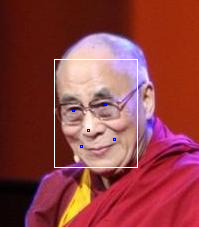

In [22]:
show_bboxes(image, bounding_boxes, landmarks)


### crop img

In [23]:
b =bounding_boxes[0].astype(np.uint8)
print(b.shape, b)

(5,) [ 54  59 137 167   0]


In [24]:
img = np.array(image)
print(img.shape)

(227, 199, 3)


In [25]:
img_crop = img[b[0]:b[2],b[1]:b[3]]
print(img_crop.shape)
cv2.imshow('', img_crop)

(83, 108, 3)


In [ ]:
# 
if not faces is None:
    c=0
    for face in faces :
        c+=1
        cv2.imshow("face{}".format(c), face)
    cv2.waitKey(0)
else:
    print("no face")